<a href="https://colab.research.google.com/github/pjgraczyk/Sensor_Predicton_SGD_Regressor/blob/main/SensorPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction**

The code you have provided performs a series of operations to load and analyze data related to spectrometry experiments. The goal of the code is to process multiple files in a folder, extract data, and store it in a single pandas dataframe. Additionally, the code performs some simple data processing tasks to extract information from the data and perform a simple analysis. 

This code can be useful in many applications such as the development and testing of new sensors in different mediums and can provide valuable insights into the behavior of light waves in these mediums.

In [ ]:
## Import necessary libraries
import glob
import os
import shutil
import zipfile
import random
import gdown
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from google.colab import drive
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score

**Mounting Google Drive**

The first step in the code is to mount Google Drive to the virtual environment where the code is being executed. The drive is mounted to the location '/content/drive' and the force_remount parameter is set to True to ensure that the drive is always remounted in case it was previously unmounted.

**Downloading the dataset**

Downloading the Dataset
Next, the code downloads the dataset from Google Drive using the gdown.download_folder function. The dataset is stored in the path variable and the destination folder for the dataset is '/content/data'. The quiet parameter is set to True to suppress any output from the function.

In [ ]:
## Accessing data

# Removing data from old run
data_dir = '/content/data'
shutil.rmtree(data_dir)

# Mount Google Drive
drive.mount('/content/drive', force_remount = True)

# Downloading the dataset
path = '/content/data'
url = 'https://drive.google.com/drive/folders/1ha7P4Mwp6_XYnUHs20460CbBC4zwNvf9'
gdown.download_folder(url, output = path, quiet=True)

Mounted at /content/drive
Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1LM9mCShE-5yAtVYFmjvT8gqgnCr9s2rW 



**Data Loading into a Pandas Dataframe**

The code then proceeds to extract the data from the multiple text files and store it in a single pandas dataframe. The code starts by using the glob library to get a list of all the files in the subfolders of the dataset. The code then creates an empty list to store the dataframes, which will be loaded one by one from the files.

For each file in the list of files, the code loads the file into a dataframe using the pd.read_csv function. The code then adds two new columns to the dataframe, sensor_number and sensor_medium, which are extracted from the file name. The dataframes are appended to the dfs list, and at the end, the list is concatenated into a single dataframe using the pd.concat function.

In [57]:
## Data loading into pandas dataframe 'df'

# Get a list of all the files in the subfolders

files = glob.glob(path + '/**/*.txt', recursive=True)

# Create an empty list to store the dataframes
dfs = []

# Load all files from folders and concatenate the resulting dataframe into one
for file in files:
    df = pd.read_csv(file, sep=',',header=None, names=['wavelength', 'amplitude'])

    # Add a column with the sensor number and sensor medium
    file_name = file.split('/')[-1]
    file_name = file_name.replace('.txt','')
    df['sensor_number'] = int(file_name.split('_')[-2][-2:])
    df['sensor_medium'] = file_name.split('_')[-1]
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

new_air_data = df[(df['sensor_medium'] == 'air') & (df['sensor_number'] == 6)][['wavelength', 'amplitude']]

**Unique values extraction and directory specification for later use**

The code above extracts the unique values of sensor_medium and sensor_number columns from a data frame df. The unique values of sensor_medium are stored in the sensor_mediums variable, and the unique values of sensor_number are stored in the sensor_numbers variable.

The directory for saving the files is also specified using the directory variable, which is the concatenation of path and /figures_actual. This directory is where the figures will be saved.

In [58]:
# Extracting the unique values for medium of measurement
sensor_mediums = df['sensor_medium'].unique()

# Extracting the unique values for sensor number
sensor_numbers = df['sensor_number'].unique()

# Specify the directory that the files have to be saved in
directory = path + '/figures_actual'


**Data Plotting**

The code is generating a graph of the data for each sensor (izo, water, air). For each unique sensor number, the code first extracts the data for that sensor from the dataframe. It then loops over each medium of measurement and plots a separate graph for each medium. The code is saving the graph for each sensor in a separate file in the specified directory, using the sensor number as the file name. The title of the graph and the legend for each medium are also added before showing the graph.

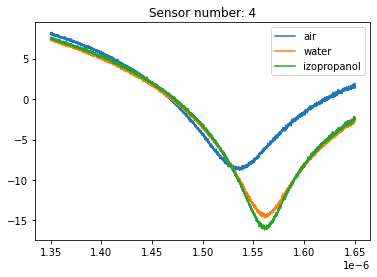

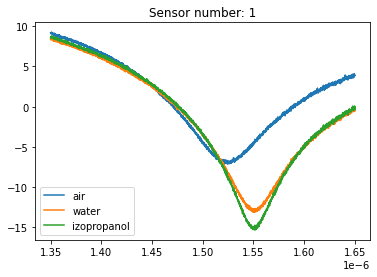

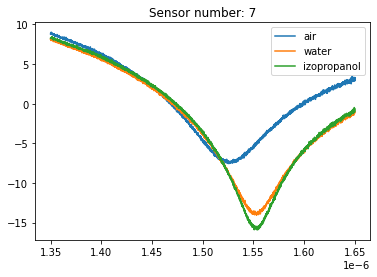

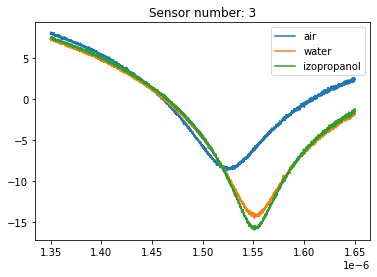

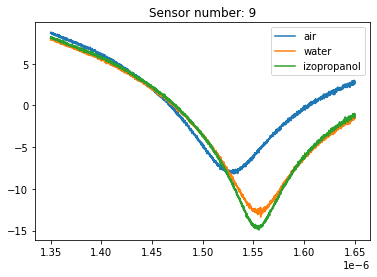

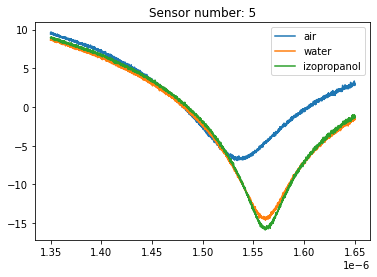

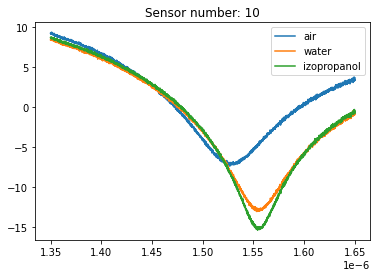

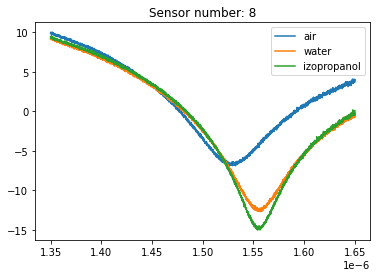

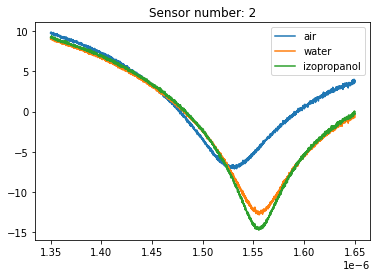

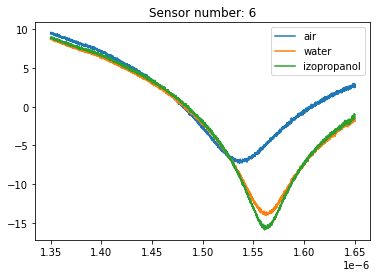

In [59]:
## Graph of data for each sensor(izo, water, air) 

# Looping over each unique sensor number
for sensor in sensor_numbers:
    
    # Extracting data for the current sensor
    sensor_df = df[df['sensor_number'] == sensor]
    
    # Plotting a separate graph for each medium of measurement
    for medium in sensor_mediums:
        
        # Extracting data for the current medium
        medium_df = sensor_df[sensor_df['sensor_medium'] == medium]
        
        # Plotting the current medium
        plt.plot(medium_df['wavelength'], medium_df['amplitude'], label=medium)

        # Make a new directory if the directory doesn't exist
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        # Generate the file name for the current sensor
        filename = 'Sensor number_{}.png'.format(sensor)
        filepath = os.path.join(directory, filename)
        
        # Check if the file already exists
        if os.path.exists(filepath):
            # Remove the file if it exists
            os.remove(filepath)
        # Get current figure
        plt.gcf()

        # Save figure
        plt.savefig(filepath, bbox_inches='tight', dpi= 100)
    
    # Setting the title of the graph based on the current sensor number
    plt.title('Sensor number: {}'.format(sensor))
    
    # Adding a legend to the graph
    plt.legend()
    
    # Showing the graph
    plt.show()

**Model**

This code performs a machine learning prediction task on optical sensor data to predict the amplitude readings of a new optical sensor in two different environments (water and izopropanol). The data is filtered for air readings and then used to train two separate models, one for water and another for izopropanol, using a third-degree polynomial feature generation and the Stochastic Gradient Descent Regressor algorithm. The models are then used to predict the amplitude readings for the new optical sensor in water and izopropanol, respectively. The predicted values are plotted and saved in a directory for future use.

In [62]:
##Model
poly_features = []
model_water = []
model_izo = []

# Filter data for air readings
air_data = df[df['sensor_medium'] == 'air']

for sensor_number in sensor_numbers:
  # Generate 3rd degree polynomial features for air data
  poly_features = PolynomialFeatures(degree=3, include_bias=False)
  air_data_poly = poly_features.fit_transform(air_data[air_data['sensor_number'] == sensor_number][['wavelength', 'amplitude']])

  # Define parameters
  params = { 
    'penalty': 'l2', 
    'alpha': 0.001, 
    'max_iter': 1000, 
    'tol': 1e-5, 
    'random_state': 13,
    'warm_start': True,
    'average': True
  } 

  # Train separate models for water and izopropanol outputs based on air data and scale y-s for data coverage
  water_pred = df[(df['sensor_medium'] == 'water') & (df['sensor_number'] == sensor_number)]['wavelength']
  model_water = SGDRegressor(**params)
  model_water.partial_fit(air_data_poly, water_pred)

  izo_pred = df[(df['sensor_medium'] == 'izopropanol') & (df['sensor_number'] == sensor_number)]['wavelength']
  model_izo = SGDRegressor(**params)
  model_izo.partial_fit(air_data_poly, izo_pred)

# Predict outputs for water and izopropanol based on some new air data
new_air_data = df[(df['sensor_medium'] == 'air') & (df['sensor_number'] == random.randint(1, 10))][['wavelength', 'amplitude']]
new_air_data_poly = poly_features.transform(new_air_data[['wavelength', 'amplitude']])
pred_water = model_water.predict(new_air_data_poly)
pred_izo = model_izo.predict(new_air_data_poly)

# Scale back the 'amplitude' of the predicted data
y_scaling_factor = 1/1e12
pred_water = pred_water * y_scaling_factor
pred_izo = pred_izo * y_scaling_factor

# Print model parameters
print(model_izo.get_params(deep=True))
print(model_water.get_params(deep=True))

# Plot predicted outputs for water and izopropanol against new air data
data = pd.DataFrame({
    'wavelength': new_air_data['wavelength'],
    'New Air': new_air_data['amplitude'],
    'Water': pred_water,
    'Izopropanol': pred_izo
})

fig = px.line(data, x='wavelength', y=['New Air', 'Water', 'Izopropanol'], color='variable', title='Predicted data for new sensor')

fig.update_layout(xaxis_title='Wavelength',
                  yaxis_title='Amplitude')

fig.show()

# Reset the models
model_water = SGDRegressor(max_iter=1000, tol=1e-3)
model_izo = SGDRegressor(max_iter=1000, tol=1e-3)

# Set up an output file
pred_data_water = np.column_stack((new_air_data['wavelength'].values, pred_water))
pred_data_izo = np.column_stack((new_air_data['wavelength'].values, pred_izo))

# Save in directory if it exists and if not then create a directory
next_sensor = len(sensor_numbers) + 1
saved_data_path = '/content/data/predicted_sensor'
if not os.path.exists(saved_data_path):
  os.mkdir(saved_data_path)
np.savetxt(saved_data_path + '/predicted_output_water_sensor' + str(next_sensor) + '.txt', pred_data_water, delimiter=',', header='wavelength,amplitude')
np.savetxt(saved_data_path + '/predicted_output_izo_sensor' + str(next_sensor) + '.txt', pred_data_izo, delimiter=',', header='wavelength,amplitude')

{'alpha': 0.001, 'average': True, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.01, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'loss': 'squared_error', 'max_iter': 1000, 'n_iter_no_change': 5, 'penalty': 'l2', 'power_t': 0.25, 'random_state': 13, 'shuffle': True, 'tol': 1e-05, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': True}
{'alpha': 0.001, 'average': True, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.01, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'loss': 'squared_error', 'max_iter': 1000, 'n_iter_no_change': 5, 'penalty': 'l2', 'power_t': 0.25, 'random_state': 13, 'shuffle': True, 'tol': 1e-05, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': True}


In [67]:
# Scale back the 'amplitude' of the water and izopropanol predictions
y_scaling_factor = 1/1e12
true_water = df[(df['sensor_medium'] == 'water') & (df['sensor_number'] == random.randint(1, 10))]['amplitude'] * y_scaling_factor
true_izo = df[(df['sensor_medium'] == 'izopropanol') & (df['sensor_number'] == random.randint(1, 10))]['amplitude'] * y_scaling_factor

# Calculate R2 scores
r2_water = r2_score(true_water, pred_water)
r2_izo = r2_score(true_izo, pred_izo)

# Print R2 scores
print("R^2 score for predicted water data: ", r2_water)
print("R^2 score for predicted izopropanol data: ", r2_izo)


R^2 score for predicted water data:  -4.728284650038263e+23
R^2 score for predicted izopropanol data:  -4.181642946263576e+23
